In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#from sklearn.feature_extraction import DictVectorizer
#from sklearn.utils.multiclass import unique_labels
# import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [10]:
Stock = pd.read_csv('IBM.csv')
#best features
features_selected = ['Open', 'High', 'Low', 'QQQ(t-1)', 'Snp(t-1)', 'DJIA(t-1)', 'Close(t)']
df_Stock = Stock[features_selected]
df_Stock = df_Stock.iloc[:-100, :]
df_Stock = df_Stock.rename(columns={'Close(t)': 'Close'})

df_Stock['Diff'] = df_Stock['Close'] - df_Stock['Open']
df_Stock['High-low'] = df_Stock['High'] - df_Stock['Low']

df_Stock.head()


,Open,High,Low,QQQ(t-1),Snp(t-1),DJIA(t-1),Close,Diff,High-low
0,43.004263,43.948008,42.999162,30.105747,74.896851,61.892120,43.830681,0.826418,0.948846
1,44.993774,45.774278,44.891749,30.536665,75.179588,62.045326,45.590633,0.596860,0.882529
2,45.121309,45.498808,45.039688,30.316982,74.546783,61.715218,45.310059,0.188750,0.459120
3,45.095811,45.279459,44.718311,30.460632,74.398697,61.584427,44.942772,-0.153039,0.561148
4,45.003998,45.121326,44.529571,30.925348,74.883362,61.615612,44.580585,-0.423413,0.591755


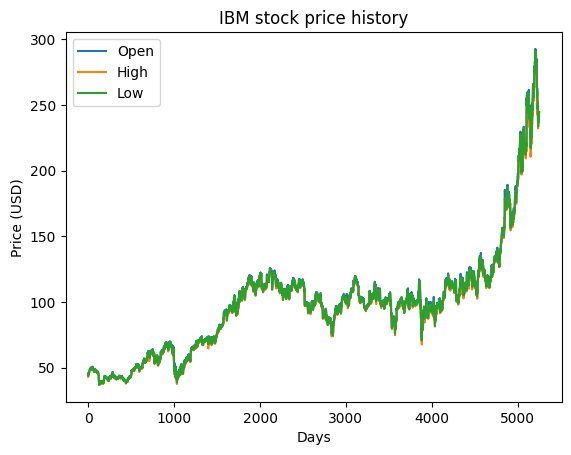

In [11]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_Stock["High"])
plt.plot(df_Stock["Low"])
plt.plot(df_Stock["Close"])
plt.title('IBM stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

In [16]:
def prepare_lagged_features(df_Stock, lag_stock, lag_index):

        print('Preparing Lagged Features for Stock, Index Funds.....')
        lags = range(1, lag_stock+1)
        lag_cols= ['Close']
        df_Stock=df_Stock.assign(**{
            '{}(t-{})'.format(col, l): df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

       
        lags = range(1, lag_index+1)
        lag_cols= ['QQQ(t-1)','Snp(t-1)','DJIA(t-1)']
        df_Stock= df_Stock.assign(**{
            '{}(t-{})'.format(col, l): df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

        df_Stock = df_Stock.drop(columns=lag_cols)


        remove_lags_na = max(lag_stock, lag_index) + 1
        print('Removing NAN rows - ', str(remove_lags_na))
        df_Stock = df_Stock.iloc[remove_lags_na:,]
        return df_Stock

In [17]:
df_Stock = prepare_lagged_features(df_Stock, lag_stock = 20, lag_index = 5)
df_Stock.head()

Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  21


,Open,High,Low,Close,Diff,High-low,Close(t-1),Close(t-2),Close(t-3),Close(t-4),...,DJIA(t-1)(t-2),QQQ(t-1)(t-3),Snp(t-1)(t-3),DJIA(t-1)(t-3),QQQ(t-1)(t-4),Snp(t-1)(t-4),DJIA(t-1)(t-4),QQQ(t-1)(t-5),Snp(t-1)(t-5),DJIA(t-1)(t-5)
21,48.684179,48.811960,48.377506,48.500175,-0.184004,0.434453,49.026630,48.719975,48.449062,47.845955,...,65.445564,31.930849,78.740669,65.009674,32.040680,78.680061,64.897491,32.108295,78.834915,64.947365
22,48.709733,49.389525,48.709733,48.791512,0.081778,0.679792,48.500175,49.026630,48.719975,48.449062,...,65.794273,32.353336,79.339783,65.445564,31.930849,78.740669,65.009674,32.040680,78.680061,64.897491
23,48.740408,48.914186,48.571737,48.607517,-0.132891,0.342449,48.791512,48.500175,49.026630,48.719975,...,65.982155,32.665951,79.965820,65.794273,32.353336,79.339783,65.445564,31.930849,78.740669,65.009674
24,48.530825,48.638162,48.173043,48.275265,-0.255560,0.465118,48.607517,48.791512,48.500175,49.026630,...,65.607658,32.809593,80.162277,65.982155,32.665951,79.965820,65.794273,32.353336,79.339783,65.445564
25,48.198623,48.760856,48.127066,48.612633,0.414010,0.633790,48.275265,48.607517,48.791512,48.500175,...,66.088287,32.606815,79.588402,65.607658,32.809593,80.162277,65.982155,32.665951,79.965820,65.794273


In [18]:
df_Stock=df_Stock.drop(columns=['Open','High', 'Low'])

In [19]:
df_Stock= df_Stock.iloc[31:452,]
df_Stock.shape

(421, 38)

In [20]:
train=df_Stock.iloc[:340,]
test=df_Stock.iloc[340:,]

In [22]:
Y_train = train[['Close']]
X_train = train[['Diff', 'High-low', 'Close(t-1)', 'Close(t-2)', 'Close(t-3)',
       'Close(t-4)', 'Close(t-5)', 'Close(t-6)', 'Close(t-7)', 'Close(t-8)',
       'Close(t-9)', 'Close(t-10)', 'Close(t-11)', 'Close(t-12)',
       'Close(t-13)', 'Close(t-14)', 'Close(t-15)', 'Close(t-16)',
       'Close(t-17)', 'Close(t-18)', 'Close(t-19)', 'Close(t-20)',
       'QQQ(t-1)(t-1)', 'Snp(t-1)(t-1)', 'DJIA(t-1)(t-1)',
       'QQQ(t-1)(t-2)', 'Snp(t-1)(t-2)', 'DJIA(t-1)(t-2)',
       'QQQ(t-1)(t-3)', 'Snp(t-1)(t-3)', 'DJIA(t-1)(t-3)',
       'QQQ(t-1)(t-4)', 'Snp(t-1)(t-4)', 'DJIA(t-1)(t-4)',
       'QQQ(t-1)(t-5)', 'Snp(t-1)(t-5)', 'DJIA(t-1)(t-5)']]

Y_test = test[['Close']]
X_test = test[['Diff', 'High-low', 'Close(t-1)', 'Close(t-2)', 'Close(t-3)',
       'Close(t-4)', 'Close(t-5)', 'Close(t-6)', 'Close(t-7)', 'Close(t-8)',
       'Close(t-9)', 'Close(t-10)', 'Close(t-11)', 'Close(t-12)',
       'Close(t-13)', 'Close(t-14)', 'Close(t-15)', 'Close(t-16)',
       'Close(t-17)', 'Close(t-18)', 'Close(t-19)', 'Close(t-20)',
       'QQQ(t-1)(t-1)', 'Snp(t-1)(t-1)', 'DJIA(t-1)(t-1)',
       'QQQ(t-1)(t-2)', 'Snp(t-1)(t-2)', 'DJIA(t-1)(t-2)',
       'QQQ(t-1)(t-3)', 'Snp(t-1)(t-3)', 'DJIA(t-1)(t-3)',
       'QQQ(t-1)(t-4)', 'Snp(t-1)(t-4)', 'DJIA(t-1)(t-4)',
       'QQQ(t-1)(t-5)', 'Snp(t-1)(t-5)', 'DJIA(t-1)(t-5)']]


In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Y_train)
x_train, y_train = [], []
for i in range(60,len(Y_train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [25]:
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
lstm.add(LSTM(units=50))
lstm.add(Dense(1))

lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history_lstm = lstm.fit(x_train, y_train, epochs=25, batch_size=5, verbose=2)

Epoch 1/25
56/56 - 3s - 49ms/step - loss: 0.0154
Epoch 2/25
56/56 - 1s - 13ms/step - loss: 0.0067
Epoch 3/25
56/56 - 1s - 12ms/step - loss: 0.0052
Epoch 4/25
56/56 - 1s - 11ms/step - loss: 0.0045
Epoch 5/25
56/56 - 1s - 12ms/step - loss: 0.0038
Epoch 6/25
56/56 - 1s - 12ms/step - loss: 0.0036
Epoch 7/25
56/56 - 1s - 11ms/step - loss: 0.0030
Epoch 8/25
56/56 - 1s - 12ms/step - loss: 0.0026
Epoch 9/25
56/56 - 1s - 15ms/step - loss: 0.0025
Epoch 10/25
56/56 - 1s - 13ms/step - loss: 0.0023
Epoch 11/25
56/56 - 1s - 12ms/step - loss: 0.0020
Epoch 12/25
56/56 - 1s - 13ms/step - loss: 0.0020
Epoch 13/25
56/56 - 1s - 13ms/step - loss: 0.0019
Epoch 14/25
56/56 - 1s - 14ms/step - loss: 0.0019
Epoch 15/25
56/56 - 1s - 14ms/step - loss: 0.0017
Epoch 16/25
56/56 - 1s - 13ms/step - loss: 0.0020
Epoch 17/25
56/56 - 1s - 16ms/step - loss: 0.0017
Epoch 18/25
56/56 - 1s - 14ms/step - loss: 0.0017
Epoch 19/25
56/56 - 1s - 15ms/step - loss: 0.0019
Epoch 20/25
56/56 - 1s - 16ms/step - loss: 0.0015
Epoch 21/

In [27]:
history_lstm.history.keys()

dict_keys(['loss'])

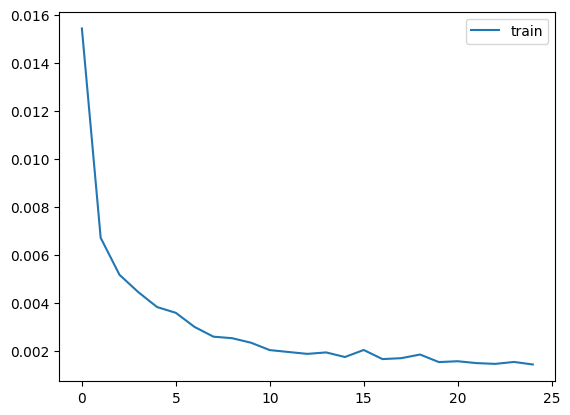

In [29]:
plt.plot(history_lstm.history['loss'], label='train')
#plt.plot(history_lstm.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
new_df_Stock = df_Stock['Close']

In [31]:
inputs = new_df_Stock[len(new_df_Stock) - len(Y_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [32]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = lstm.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


In [33]:
rms=np.sqrt(np.mean(np.power((Y_test-closing_price),2)))
rms

0.4206316553264828

In [34]:
closing_price

array([[42.976936],
       [43.148075],
       [43.124252],
       [42.91087 ],
       [42.719303],
       [42.77684 ],
       [42.661434],
       [42.297695],
       [41.880405],
       [41.56653 ],
       [41.389206],
       [41.31312 ],
       [41.31514 ],
       [41.4541  ],
       [41.741558],
       [41.78226 ],
       [41.659306],
       [41.749886],
       [41.538147],
       [41.21749 ],
       [41.198742],
       [41.12081 ],
       [40.53953 ],
       [40.25589 ],
       [40.054844],
       [39.96898 ],
       [40.149982],
       [40.535484],
       [40.67125 ],
       [40.60152 ],
       [40.56551 ],
       [40.616344],
       [40.400406],
       [40.18136 ],
       [40.070198],
       [39.926613],
       [39.83083 ],
       [40.02791 ],
       [40.058315],
       [40.30148 ],
       [40.44256 ],
       [40.561596],
       [40.228237],
       [39.965973],
       [39.793808],
       [39.515427],
       [39.085003],
       [38.687656],
       [38.516853],
       [38.605076],


In [35]:
closing_price.shape

(81, 1)

In [36]:
Y_test

,Close
392,43.203838
393,43.032520
394,42.804119
395,42.767796
396,43.027348
...,...
468,41.630253
469,41.859573
470,42.422413
471,42.328602


In [37]:
def get_mape(y_true, y_pred): 
        """
        Compute mean absolute percentage error (MAPE)
        """
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [38]:
print('R2 - ',round(metrics.r2_score(Y_test.Close,closing_price),2))
print('MAPE - ', round(get_mape(Y_test.Close,closing_price), 2))
print('RMSE -', round(np.sqrt(metrics.mean_squared_error(Y_test.Close,closing_price)),2))
print('MAE - ', round(metrics.mean_absolute_error(Y_test.Close,closing_price),2))


R2 -  0.88
MAPE -  3.27
RMSE - 0.42
MAE -  0.34


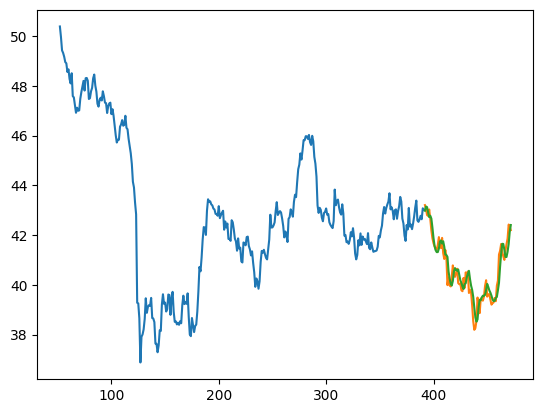

In [39]:
#for plotting
test_result=Y_test
test_result['predict']=closing_price
plt.plot(train['Close'])
plt.plot(test_result[['Close','predict']])